# Full Image Enhancement Inference

## Objective
This notebook performs full image enhancement using the trained illumination
and reflectance refinement models. No training is performed.
The enhanced images are saved for downstream object detection.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
BASE_PATH = "../data/LOL"
LOW_DIR = os.path.join(BASE_PATH, "eval15", "low")

RESULTS_DIR = "../results/enhanced_images"
os.makedirs(RESULTS_DIR, exist_ok=True)
#C:\IMAGE_ENHANCEMENT_YOLO_DETECTION\results\illumination_net_best_totalLol_training.pth
ILLUM_MODEL_PATH = "../results/illumination_net_best_totalLol_training.pth"
REFINE_MODEL_PATH = "../results/reflectance_refine_net_50epoch_TotalLoL.pth"


In [4]:
class LOLInferenceDataset(Dataset):
    def __init__(self, low_dir):
        self.low_dir = low_dir
        self.images = sorted(os.listdir(low_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = cv2.imread(os.path.join(self.low_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img, (256, 256))
        img = torch.from_numpy(img / 255.0).float().permute(2, 0, 1)

        return img, img_name


In [5]:
class IlluminationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)


class MultiScaleUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))

        d2 = self.up2(b)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [7]:
illum_model = IlluminationNet().to(device)
illum_model.load_state_dict(torch.load(ILLUM_MODEL_PATH, map_location=device))
illum_model.eval()

refine_model = MultiScaleUNet().to(device)
refine_model.load_state_dict(torch.load(REFINE_MODEL_PATH, map_location=device))
refine_model.eval()

print("Models loaded successfully.")


Models loaded successfully.


In [8]:
def correct_illumination(img, illum, eps=1e-4):
    return img / (illum + eps)


In [9]:
dataset = LOLInferenceDataset(LOW_DIR)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for img, name in loader:
        img = img.to(device)

        illum = illum_model(img)
        illum_corrected = correct_illumination(img, illum)
        refined = refine_model(illum_corrected)

        enhanced = refined.squeeze().permute(1,2,0).cpu().numpy()
        enhanced = np.clip(enhanced * 255, 0, 255).astype(np.uint8)

        save_path = os.path.join(RESULTS_DIR, name[0])
        cv2.imwrite(save_path, cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))

print("All enhanced images saved.")


All enhanced images saved.


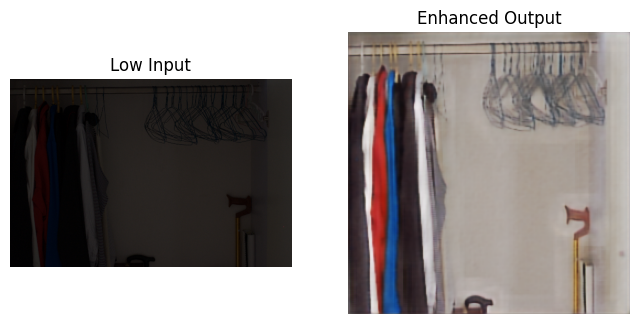

In [10]:
sample = os.listdir(RESULTS_DIR)[2]

low = cv2.imread(os.path.join(LOW_DIR, sample))
enh = cv2.imread(os.path.join(RESULTS_DIR, sample))

low = cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
enh = cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(low); plt.title("Low Input"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(enh); plt.title("Enhanced Output"); plt.axis("off")
plt.show()
